### Specifying Seasonalities
* Prophetはデフォルトで、週次・年次の季節性にフィットする。時系列が2サイクル以上あれば。
* また1日より短い単位の時系列データであれば、日次の季節性にフィットする。
* `add_seasonality`メソッドを用いることで、月次・四半期・時間単位の季節性を追加できる。

#### add_seasonality
* 引数に`name`,`period`として季節性の期間日数、`fourier_order`として季節性のフーリエ項をとる。
* フーリエ項の値を増やすと、季節性が変化のサイクルに早くフィットするようになる（？）。overfitに繋がる。
* フーリエ項の値 $N$ は、サイクルをモデリングするのに $2N$ の変数を用いていることに対応する（変化点が$2N$ということ？）
* Prophetはデフォルトで、週次の季節性には3、年次の季節性には10の値を用いている。`add_seasonality`へのオプションの引数は、季節成分の事前スケールである（？）

In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('./input/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

* `weekly_seasonality`を削除。`monthly`を追加している。
* `fourier_order=5`

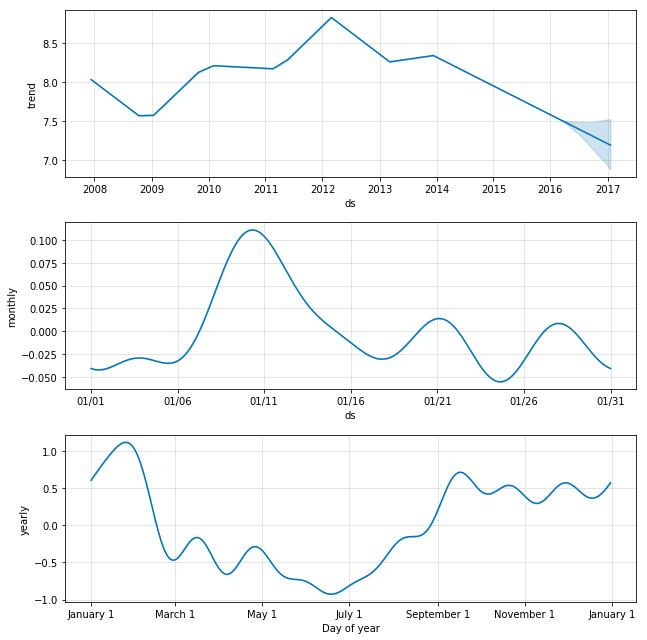

In [3]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

* `fourier_order=2`
* monthlyのグラフの波が減っている

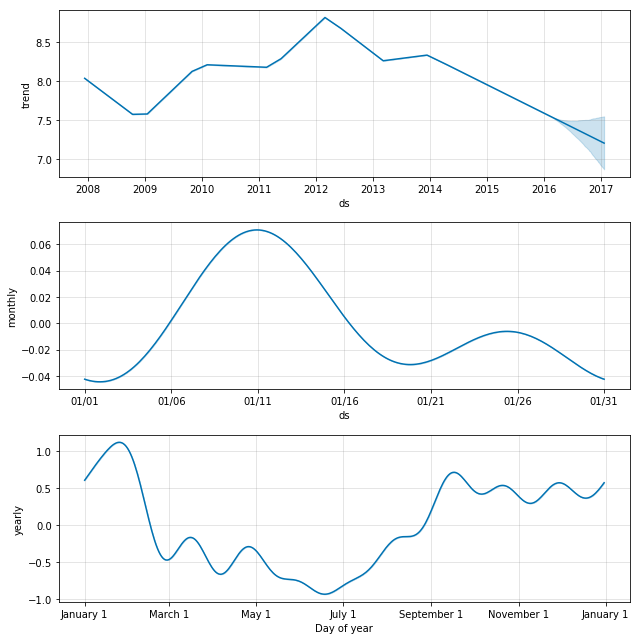

In [4]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

* `fourier_order=10`
* monthlyのグラフの波が増えた。

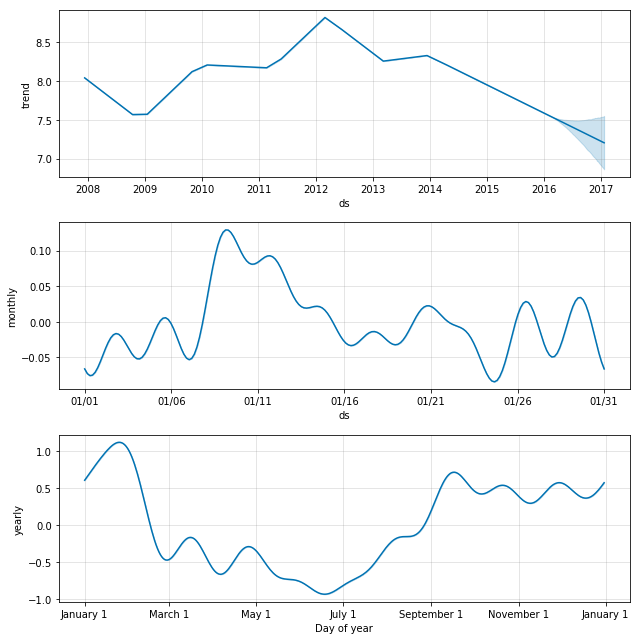

In [5]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
forecast = m.fit(df).predict(future)
m.plot_components(forecast);

### Modeling Holidays and Special Events

* 祝日やその他の定期イベントをモデルにしたければ、DataFrameを作る。`holiday`と`ds`の2つのカラム。祝日ごとに行を作成。
* 過去も未来も。
* 未来に起きないようであれば、Prophetは予測時にはそれらを含めない。

* `lower_window`と`upper_window`を用いると、祝日を拡張することができる。

In [6]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [7]:
playoffs

,ds,holiday,lower_window,upper_window
0,2008-01-13,playoff,0,1
1,2009-01-03,playoff,0,1
2,2010-01-16,playoff,0,1
3,2010-01-24,playoff,0,1
4,2010-02-07,playoff,0,1
5,2011-01-08,playoff,0,1
6,2013-01-12,playoff,0,1
7,2014-01-12,playoff,0,1
8,2014-01-19,playoff,0,1
9,2014-02-02,playoff,0,1


In [8]:
superbowls

,ds,holiday,lower_window,upper_window
0,2010-02-07,superbowl,0,1
1,2014-02-02,superbowl,0,1
2,2016-02-07,superbowl,0,1


In [9]:
holidays

,ds,holiday,lower_window,upper_window
0,2008-01-13,playoff,0,1
1,2009-01-03,playoff,0,1
2,2010-01-16,playoff,0,1
3,2010-01-24,playoff,0,1
4,2010-02-07,playoff,0,1
5,2011-01-08,playoff,0,1
6,2013-01-12,playoff,0,1
7,2014-01-12,playoff,0,1
8,2014-01-19,playoff,0,1
9,2014-02-02,playoff,0,1


* SuperBowlはPlayOffに追加でプラスの影響を与えると捉え、上記のように設定している。
* 引数として上のテーブルを与えると、予測に上記の影響を加えてくれる。

In [10]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

In [11]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.223925,1.199984
2191,2014-02-03,1.901619,1.458839
2532,2015-01-11,1.223925,0.000000
2533,2015-01-12,1.901619,0.000000
2901,2016-01-17,1.223925,0.000000
2902,2016-01-18,1.901619,0.000000
2908,2016-01-24,1.223925,0.000000
2909,2016-01-25,1.901619,0.000000
2922,2016-02-07,1.223925,1.199984
2923,2016-02-08,1.901619,1.458839


* 祝日効果はコンポーネントプロットにも現れる。playoffの付近ではスパイクしており、superbowlでは特に大きいスパイクが見られる（それほど見えない）

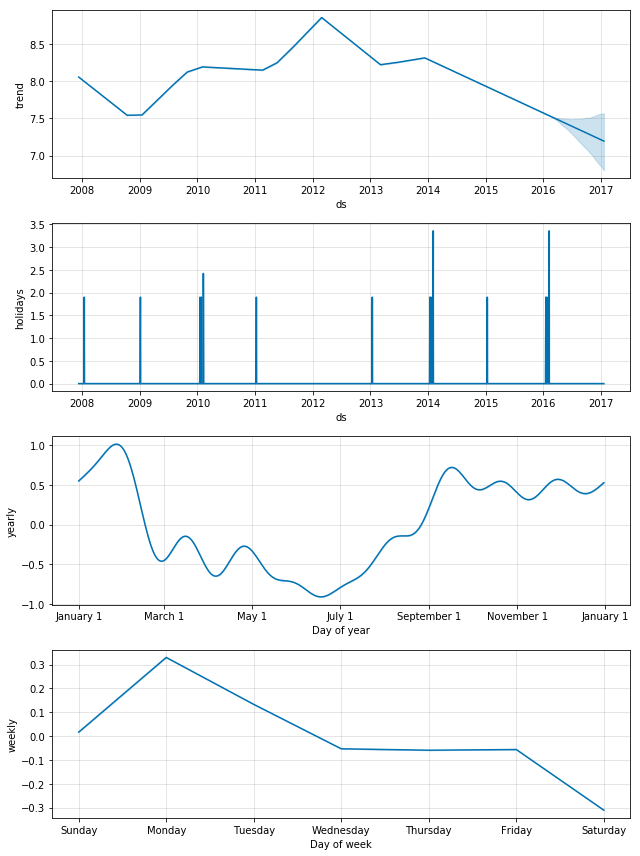

In [12]:
m.plot_components(forecast);

* 個別の祝日をプロットする場合は`plot_forecast_component`を用いれば良い

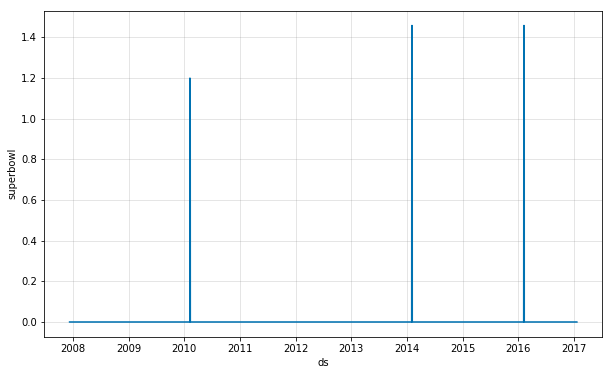

In [13]:
m.plot_forecast_component(forecast, 'superbowl') 

### 参考
* https://github.com/facebook/prophet/blob/master/notebooks/seasonality_and_holiday_effects.ipynb